## 1️⃣ Introduction

Interest rates are a key macroeconomic variable, often exhibiting complex dynamics such as trends and cycles. Accurate forecasting is crucial for policy analysis and financial decision-making. N-BEATS is a modern deep learning architecture designed for interpretable and accurate time series forecasting, making it suitable for this task.

## 2️⃣ Imports and Setup

Install dependencies if needed:
```bash
pip install torch numpy scipy matplotlib
```

Import the necessary modules:

In [22]:
import numpy as np
import torch
import scipy.io
import matplotlib.pyplot as plt
from econometron.Models.n_beats import NBeatsModel, create_sliding_windows, normalize_data, smape, mae

## 3️⃣ Load and Explore the Data

We use the first row of `Z.mat` as our interest rate series (already log HP-filtered).

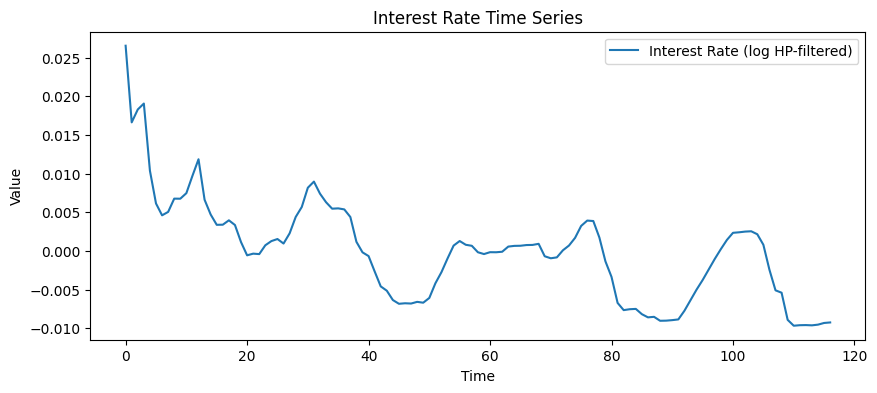

In [23]:
# Load the interest rate 
data = scipy.io.loadmat('../Z.mat')["Z"][0, :]

# Plot the raw data
plt.figure(figsize=(10, 4))
plt.plot(data, label="Interest Rate (log HP-filtered)")
plt.title("Interest Rate Time Series")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.show()

## 4️⃣ Preprocess the Data

- Create sliding windows for supervised learning
- Normalize the data for stable training
- Split into training and test sets

In [24]:
# Parameters
input_size = 20
forecast_horizon = 10

# Create sliding windows
X, y = create_sliding_windows(data, input_size, forecast_horizon)

# Normalize
X_norm, y_norm, mean, std = normalize_data(X, y)

# Train/test split
train_size = int(0.8 * len(X_norm))
X_train, y_train = X_norm[:train_size], y_norm[:train_size]
X_test, y_test = X_norm[train_size:], y_norm[train_size:]

## 5️⃣ Define and Train the N-BEATS Model

We use a stack of generic, polynomial, and Fourier blocks for flexibility.

In [25]:
stack_configs = [
    {'theta_size': input_size + forecast_horizon, 'num_blocks': 2, 'basis_type': 'generic', 'degree': 3},
    {'theta_size': 4, 'num_blocks': 2, 'basis_type': 'polynomial', 'degree': 3},
    {'theta_size': 5, 'num_blocks': 2, 'basis_type': 'fourier', 'degree': 2, 'periodicity': 50}
]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = NBeatsModel(
    input_size=input_size,
    hidden_size=512,
    forecast_horizon=forecast_horizon,
    stack_configs=stack_configs
).to(device)

# Train the model
losses = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

Epoch 20/100, Train Loss: 2.921219, Val Loss: 1.614393
Epoch 40/100, Train Loss: 0.360904, Val Loss: 2.154809
Epoch 60/100, Train Loss: 0.118243, Val Loss: 2.255154
Epoch 80/100, Train Loss: 0.054219, Val Loss: 1.538816
Epoch 100/100, Train Loss: 0.035026, Val Loss: 2.075482


## 6️⃣ Evaluate the Model

We use sMAPE and MAE as evaluation metrics.

In [26]:
forecast, _ = model.forecast(X_test)
test_smape = smape(y_test, forecast)
test_mae = mae(y_test, forecast)
print(f"Test SMAPE: {test_smape:.2f}%")
print(f"Test MAE: {test_mae:.4f}")

Test SMAPE: 137.34%
Test MAE: 1.0678


## 7️⃣ Visualize the Forecasts

Compare the predicted and actual values.

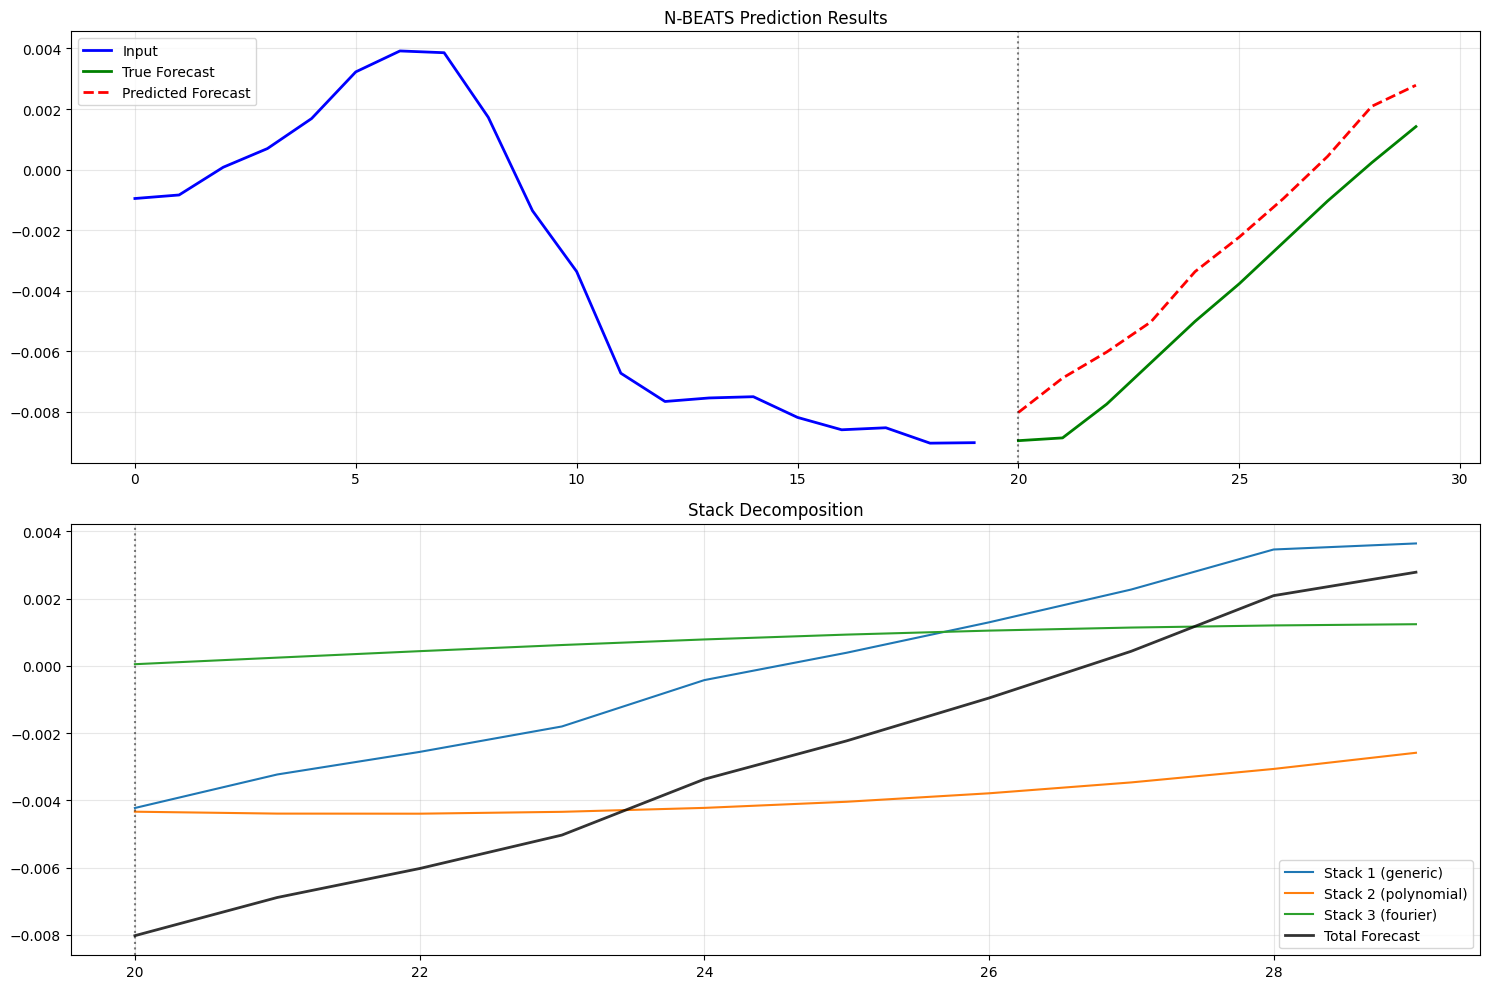

In [27]:
model.visualize(X_test, y_test, mean, std)

## 8️⃣ Conclusion

- N-BEATS can effectively model and forecast real-world macroeconomic time series.
- Proper preprocessing and model configuration are key to good performance.
- This workflow can be adapted to other economic or financial time series problems.

---

For more, see the [Econometron Documentation](https://github.com/your-repo-link).